# Assignment 4: Chấm điểm tín dụng

Tổng quan: Ở bài tập này chúng ta sẽ lần lượt thực hành các thuật toán cây quyết định, rừng ngẫu nhiên và hồi quy logistic.

## Câu hỏi 1: Khảo sát các phương pháp học máy trên cho tập dữ liệu Kaggle 
Tập dữ liệu này đã được tiền xử lý một cách tốt nhất (theo bài báo Wang et al, 2016), các phương pháp tiền xử lý đã được giới thiệu trong bài giảng

In [3]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier

sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100

In [4]:
import pandas as pd
import numpy as np

def transform_data(x):
    x['UnknownNumberOfDependents'] = pd.isna(x['NumberOfDependents']).astype(int)
    x['UnknownMonthlyIncome'] = pd.isna(x['MonthlyIncome']).astype(int)

    x['NoDependents'] = (x['NumberOfDependents'] == 0).astype(int)
    x['NoDependents'].loc[pd.isna(x['NoDependents'])] = 0

    x['NumberOfDependents'].loc[x['UnknownNumberOfDependents'] == 1] = 0

    x['NoIncome'] = (x['MonthlyIncome'] == 0).astype(int)
    x['NoIncome'].loc[pd.isna(x['NoIncome'])] = 0

    x['MonthlyIncome'].loc[x['UnknownMonthlyIncome'] == 1] = 0

    x['ZeroDebtRatio'] = (x['DebtRatio'] == 0).astype(int)
    x['UnknownIncomeDebtRatio'] = x['DebtRatio'].astype(int)
    x['UnknownIncomeDebtRatio'].loc[x['UnknownMonthlyIncome'] == 0] = 0
    x['DebtRatio'].loc[x['UnknownMonthlyIncome'] == 1] = 0

    x['WeirdRevolvingUtilization'] = x['RevolvingUtilizationOfUnsecuredLines']
    x['WeirdRevolvingUtilization'].loc[~(np.log(x['RevolvingUtilizationOfUnsecuredLines']) > 3)] = 0
    x['ZeroRevolvingUtilization'] = (x['RevolvingUtilizationOfUnsecuredLines'] == 0).astype(int)
    x['RevolvingUtilizationOfUnsecuredLines'].loc[np.log(x['RevolvingUtilizationOfUnsecuredLines']) > 3] = 0

    x['Log.Debt'] = np.log(np.maximum(x['MonthlyIncome'], np.repeat(1, x.shape[0])) * x['DebtRatio'])
    x['Log.Debt'].loc[~np.isfinite(x['Log.Debt'])] = 0

    x['RevolvingLines'] = x['NumberOfOpenCreditLinesAndLoans'] - x['NumberRealEstateLoansOrLines']

    x['HasRevolvingLines'] = (x['RevolvingLines'] > 0).astype(int)
    x['HasRealEstateLoans'] = (x['NumberRealEstateLoansOrLines'] > 0).astype(int)
    x['HasMultipleRealEstateLoans'] = (x['NumberRealEstateLoansOrLines'] > 2).astype(int)
    x['EligibleSS'] = (x['age'] >= 60).astype(int)
    x['DTIOver33'] = ((x['NoIncome'] == 0) & (x['DebtRatio'] > 0.33)).astype(int)
    x['DTIOver43'] = ((x['NoIncome'] == 0) & (x['DebtRatio'] > 0.43)).astype(int)
    x['DisposableIncome'] = (1 - x['DebtRatio'])*x['MonthlyIncome']
    x['DisposableIncome'].loc[x['NoIncome'] == 1] = 0

    x['RevolvingToRealEstate'] = x['RevolvingLines'] / (1 + x['NumberRealEstateLoansOrLines'])

    x['NumberOfTime30-59DaysPastDueNotWorseLarge'] = (x['NumberOfTime30-59DaysPastDueNotWorse'] > 90).astype(int)
    x['NumberOfTime30-59DaysPastDueNotWorse96'] = (x['NumberOfTime30-59DaysPastDueNotWorse'] == 96).astype(int)
    x['NumberOfTime30-59DaysPastDueNotWorse98'] = (x['NumberOfTime30-59DaysPastDueNotWorse'] == 98).astype(int)
    x['Never30-59DaysPastDueNotWorse'] = (x['NumberOfTime30-59DaysPastDueNotWorse'] == 0).astype(int)
    x['NumberOfTime30-59DaysPastDueNotWorse'].loc[x['NumberOfTime30-59DaysPastDueNotWorse'] > 90] = 0

    x['NumberOfTime60-89DaysPastDueNotWorseLarge'] = (x['NumberOfTime60-89DaysPastDueNotWorse'] > 90).astype(int)
    x['NumberOfTime60-89DaysPastDueNotWorse96'] = (x['NumberOfTime60-89DaysPastDueNotWorse'] == 96).astype(int)
    x['NumberOfTime60-89DaysPastDueNotWorse98'] = (x['NumberOfTime60-89DaysPastDueNotWorse'] == 98).astype(int)
    x['Never60-89DaysPastDueNotWorse'] = (x['NumberOfTime60-89DaysPastDueNotWorse'] == 0).astype(int)
    x['NumberOfTime60-89DaysPastDueNotWorse'].loc[x['NumberOfTime60-89DaysPastDueNotWorse'] > 90] = 0

    x['NumberOfTimes90DaysLateLarge'] = (x['NumberOfTimes90DaysLate'] > 90).astype(int)
    x['NumberOfTimes90DaysLate96'] = (x['NumberOfTimes90DaysLate'] == 96).astype(int)
    x['NumberOfTimes90DaysLate98'] = (x['NumberOfTimes90DaysLate'] == 98).astype(int)
    x['Never90DaysLate'] = (x['NumberOfTimes90DaysLate'] == 0).astype(int)
    x['NumberOfTimes90DaysLate'].loc[x['NumberOfTimes90DaysLate'] > 90] = 0

    x['IncomeDivBy10'] = ((x['MonthlyIncome'] % 10) == 0).astype(int)
    x['IncomeDivBy100'] = ((x['MonthlyIncome'] % 100) == 0).astype(int)
    x['IncomeDivBy1000'] = ((x['MonthlyIncome'] % 1000) == 0).astype(int)
    x['IncomeDivBy5000'] = ((x['MonthlyIncome'] % 5000) == 0).astype(int)
    x['Weird0999Utilization'] = (x['RevolvingUtilizationOfUnsecuredLines'] == 0.9999998999999999).astype(int)
    x['FullUtilization'] = (x['RevolvingUtilizationOfUnsecuredLines'] == 1).astype(int)
    x['ExcessUtilization'] = (x['RevolvingUtilizationOfUnsecuredLines'] > 1).astype(int)

    x['NumberOfTime30-89DaysPastDueNotWorse'] = x['NumberOfTime30-59DaysPastDueNotWorse'] + x['NumberOfTime60-89DaysPastDueNotWorse']
    x['Never30-89DaysPastDueNotWorse'] = x['Never60-89DaysPastDueNotWorse'] * x['Never30-59DaysPastDueNotWorse']

    x['NumberOfTimesPastDue'] = x['NumberOfTime30-59DaysPastDueNotWorse'] + x['NumberOfTime60-89DaysPastDueNotWorse'] + x['NumberOfTimes90DaysLate']
    x['NeverPastDue'] = x['Never90DaysLate'] * x['Never60-89DaysPastDueNotWorse'] * x['Never30-59DaysPastDueNotWorse']
    x['Log.RevolvingUtilizationTimesLines'] = np.log1p(x['RevolvingLines'] * x['RevolvingUtilizationOfUnsecuredLines'])

    x['Log.RevolvingUtilizationOfUnsecuredLines'] = np.log(x['RevolvingUtilizationOfUnsecuredLines'])
    x['Log.RevolvingUtilizationOfUnsecuredLines'].loc[pd.isna(x['Log.RevolvingUtilizationOfUnsecuredLines'])] = 0
    x['Log.RevolvingUtilizationOfUnsecuredLines'].loc[~np.isfinite(x['Log.RevolvingUtilizationOfUnsecuredLines'])] = 0
    x = x.drop('RevolvingUtilizationOfUnsecuredLines', axis=1)

    x['DelinquenciesPerLine'] = x['NumberOfTimesPastDue'] / x['NumberOfOpenCreditLinesAndLoans']
    x['DelinquenciesPerLine'].loc[x['NumberOfOpenCreditLinesAndLoans'] == 0] = 0
    x['MajorDelinquenciesPerLine'] = x['NumberOfTimes90DaysLate'] / x['NumberOfOpenCreditLinesAndLoans']
    x['MajorDelinquenciesPerLine'].loc[x['NumberOfOpenCreditLinesAndLoans'] == 0] = 0
    x['MinorDelinquenciesPerLine'] = x['NumberOfTime30-89DaysPastDueNotWorse'] / x['NumberOfOpenCreditLinesAndLoans']
    x['MinorDelinquenciesPerLine'].loc[x['NumberOfOpenCreditLinesAndLoans'] == 0] = 0

    # Now delinquencies per revolving
    x['DelinquenciesPerRevolvingLine'] = x['NumberOfTimesPastDue'] / x['RevolvingLines']
    x['DelinquenciesPerRevolvingLine'].loc[x['RevolvingLines'] == 0] = 0
    x['MajorDelinquenciesPerRevolvingLine'] = x['NumberOfTimes90DaysLate'] / x['RevolvingLines']
    x['MajorDelinquenciesPerRevolvingLine'].loc[x['RevolvingLines'] == 0] = 0
    x['MinorDelinquenciesPerRevolvingLine'] = x['NumberOfTime30-89DaysPastDueNotWorse'] / x['RevolvingLines']
    x['MinorDelinquenciesPerRevolvingLine'].loc[x['RevolvingLines'] == 0] = 0

    x['Log.DebtPerLine'] = x['Log.Debt'] - np.log1p(x['NumberOfOpenCreditLinesAndLoans'])
    x['Log.DebtPerRealEstateLine'] = x['Log.Debt'] - np.log1p(x['NumberRealEstateLoansOrLines'])
    x['Log.DebtPerPerson'] = x['Log.Debt'] - np.log1p(x['NumberOfDependents'])
    x['RevolvingLinesPerPerson'] = x['RevolvingLines'] / (1 + x['NumberOfDependents'])
    x['RealEstateLoansPerPerson'] = x['NumberRealEstateLoansOrLines'] / (1 + x['NumberOfDependents'])
    x['UnknownNumberOfDependents'] = (x['UnknownNumberOfDependents']).astype(int)
    x['YearsOfAgePerDependent'] = x['age'] / (1 + x['NumberOfDependents'])

    x['Log.MonthlyIncome'] = np.log(x['MonthlyIncome'])
    x['Log.MonthlyIncome'].loc[~np.isfinite(x['Log.MonthlyIncome']) | np.isnan(x['Log.MonthlyIncome'])] = 0
    x = x.drop('MonthlyIncome', axis=1)
    x['Log.IncomePerPerson'] = x['Log.MonthlyIncome'] - np.log1p(x['NumberOfDependents'])
    x['Log.IncomeAge'] = x['Log.MonthlyIncome'] - np.log1p(x['age'])

    x['Log.NumberOfTimesPastDue'] = np.log(x['NumberOfTimesPastDue'])
    x['Log.NumberOfTimesPastDue'].loc[~np.isfinite(x['Log.NumberOfTimesPastDue'])] = 0

    x['Log.NumberOfTimes90DaysLate'] = np.log(x['NumberOfTimes90DaysLate'])
    x['Log.NumberOfTimes90DaysLate'].loc[~np.isfinite(x['Log.NumberOfTimes90DaysLate'])] = 0

    x['Log.NumberOfTime30-59DaysPastDueNotWorse'] = np.log(x['NumberOfTime30-59DaysPastDueNotWorse'])
    x['Log.NumberOfTime30-59DaysPastDueNotWorse'].loc[~np.isfinite(x['Log.NumberOfTime30-59DaysPastDueNotWorse'])] = 0

    x['Log.NumberOfTime60-89DaysPastDueNotWorse'] = np.log(x['NumberOfTime60-89DaysPastDueNotWorse'])
    x['Log.NumberOfTime60-89DaysPastDueNotWorse'].loc[~np.isfinite(x['Log.NumberOfTime60-89DaysPastDueNotWorse'])] = 0

    x['Log.Ratio90to30-59DaysLate'] = x['Log.NumberOfTimes90DaysLate'] - x['Log.NumberOfTime30-59DaysPastDueNotWorse']
    x['Log.Ratio90to60-89DaysLate'] = x['Log.NumberOfTimes90DaysLate'] - x['Log.NumberOfTime60-89DaysPastDueNotWorse']

    x['AnyOpenCreditLinesOrLoans'] = (x['NumberOfOpenCreditLinesAndLoans'] > 0).astype(int)
    x['Log.NumberOfOpenCreditLinesAndLoans'] = np.log(x['NumberOfOpenCreditLinesAndLoans'])
    x['Log.NumberOfOpenCreditLinesAndLoans'].loc[~np.isfinite(x['Log.NumberOfOpenCreditLinesAndLoans'])] = 0
    x['Log.NumberOfOpenCreditLinesAndLoansPerPerson'] = x['Log.NumberOfOpenCreditLinesAndLoans'] - np.log1p(x['NumberOfDependents'])

    x['Has.Dependents'] = (x['NumberOfDependents'] > 0).astype(int)
    x['Log.HouseholdSize'] = np.log1p(x['NumberOfDependents'])
    x = x.drop('NumberOfDependents', axis=1)

    x['Log.DebtRatio'] = np.log(x['DebtRatio'])
    x['Log.DebtRatio'].loc[~np.isfinite(x['Log.DebtRatio'])] = 0
    x = x.drop('DebtRatio', axis=1)

    x['Log.DebtPerDelinquency'] = x['Log.Debt'] - np.log1p(x['NumberOfTimesPastDue'])
    x['Log.DebtPer90DaysLate'] = x['Log.Debt'] - np.log1p(x['NumberOfTimes90DaysLate'])

    x['Log.UnknownIncomeDebtRatio'] = np.log(x['UnknownIncomeDebtRatio'])
    x['Log.UnknownIncomeDebtRatio'].loc[~np.isfinite(x['Log.UnknownIncomeDebtRatio'])] = 0
    # x['IntegralDebtRatio'] = None
    x['Log.UnknownIncomeDebtRatioPerPerson'] = x['Log.UnknownIncomeDebtRatio'] - x['Log.HouseholdSize']
    x['Log.UnknownIncomeDebtRatioPerLine'] = x['Log.UnknownIncomeDebtRatio'] - np.log1p(x['NumberOfOpenCreditLinesAndLoans'])
    x['Log.UnknownIncomeDebtRatioPerRealEstateLine'] = x['Log.UnknownIncomeDebtRatio'] - np.log1p(x['NumberRealEstateLoansOrLines'])
    x['Log.UnknownIncomeDebtRatioPerDelinquency'] = x['Log.UnknownIncomeDebtRatio'] - np.log1p(x['NumberOfTimesPastDue'])
    x['Log.UnknownIncomeDebtRatioPer90DaysLate'] = x['Log.UnknownIncomeDebtRatio'] - np.log1p(x['NumberOfTimes90DaysLate'])

    x['Log.NumberRealEstateLoansOrLines'] = np.log(x['NumberRealEstateLoansOrLines'])
    x['Log.NumberRealEstateLoansOrLines'].loc[~np.isfinite(x['Log.NumberRealEstateLoansOrLines'])] = 0
    x = x.drop('NumberRealEstateLoansOrLines', axis=1)

    x = x.drop('NumberOfOpenCreditLinesAndLoans', axis=1)

    x = x.drop('NumberOfTimesPastDue', axis=1)
    x = x.drop('NumberOfTimes90DaysLate', axis=1)
    x = x.drop('NumberOfTime30-59DaysPastDueNotWorse', axis=1)
    x = x.drop('NumberOfTime60-89DaysPastDueNotWorse', axis=1)

    x['LowAge'] = (x['age'] < 18) * 1
    x['Log.age'] = np.log(x['age'] - 17)
    x['Log.age'].loc[x['LowAge'] == 1] = 0
    x = x.drop('age', axis=1)
    return x

kaggle_data = pd.read_csv("./data/cs-training.csv")
kaggle_data.drop(['Unnamed: 0'], axis=1, inplace=True)
process_data = transform_data(kaggle_data)
process_data.head()

,SeriousDlqin2yrs,UnknownNumberOfDependents,UnknownMonthlyIncome,NoDependents,NoIncome,ZeroDebtRatio,UnknownIncomeDebtRatio,WeirdRevolvingUtilization,ZeroRevolvingUtilization,Log.Debt,RevolvingLines,HasRevolvingLines,HasRealEstateLoans,HasMultipleRealEstateLoans,EligibleSS,DTIOver33,DTIOver43,DisposableIncome,RevolvingToRealEstate,NumberOfTime30-59DaysPastDueNotWorseLarge,NumberOfTime30-59DaysPastDueNotWorse96,NumberOfTime30-59DaysPastDueNotWorse98,Never30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorseLarge,NumberOfTime60-89DaysPastDueNotWorse96,NumberOfTime60-89DaysPastDueNotWorse98,Never60-89DaysPastDueNotWorse,NumberOfTimes90DaysLateLarge,NumberOfTimes90DaysLate96,NumberOfTimes90DaysLate98,Never90DaysLate,IncomeDivBy10,IncomeDivBy100,IncomeDivBy1000,IncomeDivBy5000,Weird0999Utilization,FullUtilization,ExcessUtilization,NumberOfTime30-89DaysPastDueNotWorse,Never30-89DaysPastDueNotWorse,NeverPastDue,Log.RevolvingUtilizationTimesLines,Log.RevolvingUtilizationOfUnsecuredLines,DelinquenciesPerLine,MajorDelinquenciesPerLine,MinorDelinquenciesPerLine,DelinquenciesPerRevolvingLine,MajorDelinquenciesPerRevolvingLine,MinorDelinquenciesPerRevolvingLine,Log.DebtPerLine,Log.DebtPerRealEstateLine,Log.DebtPerPerson,RevolvingLinesPerPerson,RealEstateLoansPerPerson,YearsOfAgePerDependent,Log.MonthlyIncome,Log.IncomePerPerson,Log.IncomeAge,Log.NumberOfTimesPastDue,Log.NumberOfTimes90DaysLate,Log.NumberOfTime30-59DaysPastDueNotWorse,Log.NumberOfTime60-89DaysPastDueNotWorse,Log.Ratio90to30-59DaysLate,Log.Ratio90to60-89DaysLate,AnyOpenCreditLinesOrLoans,Log.NumberOfOpenCreditLinesAndLoans,Log.NumberOfOpenCreditLinesAndLoansPerPerson,Has.Dependents,Log.HouseholdSize,Log.DebtRatio,Log.DebtPerDelinquency,Log.DebtPer90DaysLate,Log.UnknownIncomeDebtRatio,Log.UnknownIncomeDebtRatioPerPerson,Log.UnknownIncomeDebtRatioPerLine,Log.UnknownIncomeDebtRatioPerRealEstateLine,Log.UnknownIncomeDebtRatioPerDelinquency,Log.UnknownIncomeDebtRatioPer90DaysLate,Log.NumberRealEstateLoansOrLines,LowAge,Log.age
0,1,0,0,0,0,0,0,0.0,0,8.898802,7,1,1,1,0,1,1,1796.802984,1.0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,2,0,0,1.850482,-0.266408,0.153846,0.0,0.153846,0.285714,0.0,0.285714,6.259745,6.952892,7.800190,2.333333,2.0,15.0,9.118225,8.019613,5.289584,0.693147,0.0,0.693147,0.0,-0.693147,0.0,1,2.564949,1.466337,1,1.098612,-0.219423,7.800190,8.898802,0.0,-1.098612,-2.639057,-1.945910,-1.098612,0.000000,1.791759,0,3.332205
1,0,0,0,0,0,0,0,0.0,0,5.758517,4,1,0,0,0,0,0,2283.121877,4.0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1.574557,-0.043794,0.000000,0.0,0.000000,0.000000,0.0,0.000000,4.149079,5.758517,5.065370,2.000000,0.0,20.0,7.863267,7.170120,4.149695,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,1.386294,0.693147,1,0.693147,-2.104749,5.758517,5.758517,0.0,-0.693147,-1.609438,0.000000,0.000000,0.000000,0.000000,0,3.135494
2,0,0,0,1,0,0,0,0.0,0,5.556499,2,1,0,0,0,0,0,2783.085113,2.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.839997,-0.418277,1.000000,0.5,0.500000,1.000000,0.5,0.500000,4.457887,5.556499,5.556499,2.000000,0.0,38.0,8.020270,8.020270,4.356709,0.693147,0.0,0.000000,0.0,0.000000,0.0,1,0.693147,0.693147,0,0.000000,-2.463771,4.457887,4.863352,0.0,0.000000,-1.098612,0.000000,-1.098612,-0.693147,0.000000,0,3.044522
3,0,0,0,1,0,0,0,0.0,0,4.778821,5,1,0,0,0,0,0,3181.036049,5.0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0.774289,-1.453247,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2.987061,4.778821,4.778821,5.000000,0.0,30.0,8.101678,8.101678,4.667691,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,1.609438,1.609438,0,0.000000,-3.322857,4.778821,4.778821,0.0,0.000000,-1.791759,0.000000,0.000000,0.000000,0.000000,0,2.564949
4,0,0,0,1,0,0,0,0.0,0,7.368324,6,1,1,0,0,0,0,62003.024906,3.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1.863062,-0.097349,0.142857,0.0,0.142857,0.166667,0.0,0.166667,5.288882,6.675177,7.368324,6.000000,1.0,49.0,11.060180,11.060180,7.148157,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,1.945910,1.945910,0,0.000000,-3.691856,6.675177,7.368324,0.0

### Câu hỏi 1.1: Áp dụng thuật toán cây ra quyết định và đánh giá hiệu năng của thuật toán
Phân chia dữ liệu tiền xử lý thành dữ liệu huấn luyện và kiểm ta, áp dụng thuật toán cây quyết định, đánh giá 
hiệu năng (tính auc) của thuật toán, tính độ quan trọng của các thuộc tính

Độ chính xác tập huấn luyện: 0.9721
Độ chính xác tập kiểm tra: 0.9211
auc on training data: 0.9502
auc on test data: 0.6399


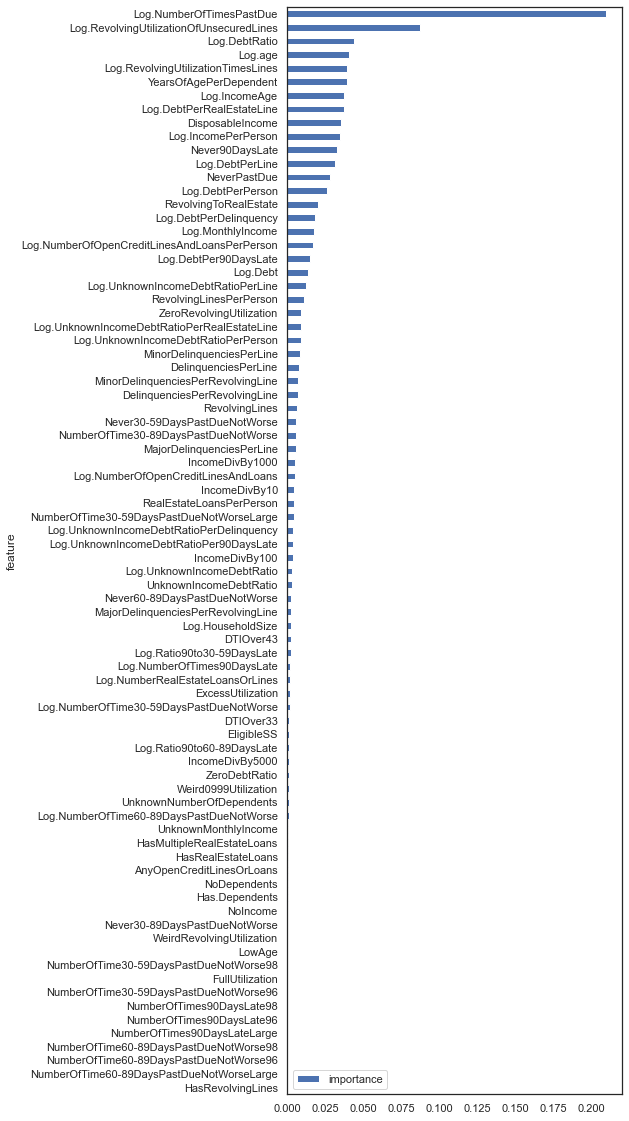

In [15]:
#### YOUR CODE HERE ####
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


y_data = process_data[process_data.columns.values[0]]
x_data = process_data.drop(process_data.columns.values[0],axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
tree_classifier = DecisionTreeClassifier(max_depth=18)
tree_classifier.fit(x_train, y_train)

from sklearn.metrics import roc_auc_score
y_train_prob_pred = tree_classifier.predict_proba(x_train)[:,1]
y_test_prob_pred = tree_classifier.predict_proba(x_test)[:,1]
print('Độ chính xác tập huấn luyện: {:.4f}'.format(tree_classifier.score(x_train, y_train)))
print('Độ chính xác tập kiểm tra: {:.4f}'.format(tree_classifier.score(x_test, y_test)))
print('auc on training data: {:.4f}'.format(roc_auc_score(y_train, y_train_prob_pred)))
print('auc on test data: {:.4f}'.format(roc_auc_score(y_test, y_test_prob_pred)))


# fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
# metrics.auc(fpr, tpr)

# print(classifier.feature_importances_)
features = x_train.columns.values

import matplotlib.pyplot as plt
features = pd.DataFrame()
features['feature'] = x_train.columns
features['importance'] = tree_classifier.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(6, 20))

#### END YOUR CODE #####

### Câu hỏi 1.2: Áp dụng thuật toán rừng ngẫu nhiên và đánh giá hiệu năng của thuật toán
Phân chia dữ liệu tiền xử lý thành dữ liệu huấn luyện và kiểm ta, áp dụng thuật toán rừng ngẫu nhiên, đánh giá 
hiệu năng (tính auc) của thuật toán, tính độ quan trọng của các thuộc tính

Độ chính xác tập huấn luyện: 0.9997
Độ chính xác tập kiểm tra: 0.9370
auc on training data: 1.0000
auc on test data: 0.8418


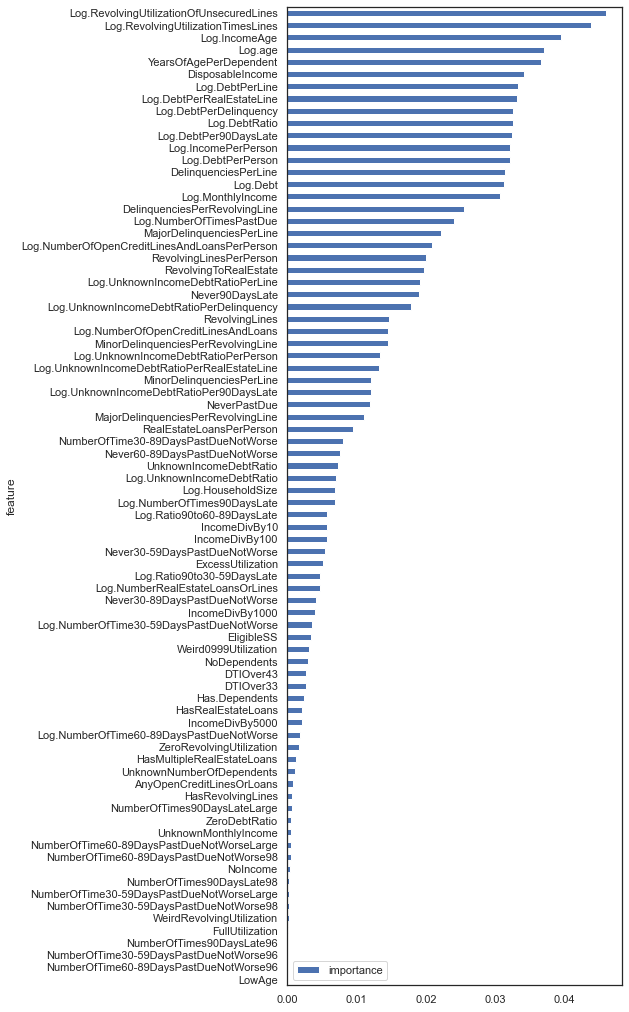

In [11]:
#### YOUR CODE HERE ####

from sklearn.ensemble import RandomForestClassifier


y_data = process_data[process_data.columns.values[0]]
x_data = process_data.drop(process_data.columns.values[0],axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
    
modelForest = RandomForestClassifier(n_estimators=100, random_state=42)
modelForest.fit(x_train, y_train)

y_train_prob_pred = modelForest.predict_proba(x_train)[:,1]
y_test_prob_pred = modelForest.predict_proba(x_test)[:,1]
print('Độ chính xác tập huấn luyện: {:.4f}'.format(modelForest.score(x_train, y_train)))
print('Độ chính xác tập kiểm tra: {:.4f}'.format(modelForest.score(x_test, y_test)))
print('auc on training data: {:.4f}'.format(roc_auc_score(y_train, y_train_prob_pred)))
print('auc on test data: {:.4f}'.format(roc_auc_score(y_test, y_test_prob_pred)))
import matplotlib.pyplot as plt

features = pd.DataFrame()
features['feature'] = x_train.columns
features['importance'] = modelForest.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(6 , 18))

#### END YOUR CODE #####

### Câu hỏi 1.3: Áp dụng thuật toán hồi quy logistic và đánh giá hiệu năng của thuật toán
Phân chia dữ liệu tiền xử lý thành dữ liệu huấn luyện và kiểm ta, áp dụng thuật toán hồi quy logistic, đánh giá 
hiệu năng (tính auc) của thuật toán, hiện thị hệ số của hồi quy logistic

In [20]:
#### YOUR CODE HERE ####
from sklearn.linear_model import LogisticRegression


y_data = process_data[process_data.columns.values[0]]
x_data = process_data.drop(process_data.columns.values[0],axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
logis_model = LogisticRegression(C=0.1)
logis_model.fit(x_train, y_train)


y_train_prob_pred = logis_model.predict_proba(x_train)[:,1]
y_test_prob_pred = logis_model.predict_proba(x_test)[:,1]
print('Độ chính xác tập huấn luyện: {:.4f}'.format(logis_model.score(x_train, y_train)))
print('Độ chính xác tập kiểm tra: {:.4f}'.format(logis_model.score(x_test, y_test)))
print('auc on training data: {:.4f}'.format(roc_auc_score(y_train, y_train_prob_pred)))
print('auc on test data: {:.4f}'.format(roc_auc_score(y_test, y_test_prob_pred)))

print("Hệ số  của hồi quy logistic: ", logis_model.intercept_, logis_model.coef_)

Độ chính xác tập huấn luyện: 0.9334
Độ chính xác tập kiểm tra: 0.9344
auc on training data: 0.7893
auc on test data: 0.7943
Hệ số  của hồi quy logistic:  [-0.02577635] [[-2.58348441e-03 -1.58943991e-02  1.25986509e-02 -2.70241623e-03
  -4.83663811e-03  1.50265816e-04  3.32785061e-04 -1.17317155e-02
  -1.26619991e-02 -4.57127298e-02 -2.95154882e-02 -1.80522225e-02
   4.61372383e-03 -7.42170442e-03  9.52340140e-03  1.24081908e-02
  -2.70808580e-05 -3.50234106e-02  1.92329472e-03  4.42651509e-05
   1.87902957e-03 -8.11255642e-02  1.92329472e-03  4.42651509e-05
   1.87902957e-03 -6.39355437e-02  1.92329472e-03  4.42651509e-05
   1.87902957e-03 -7.50467268e-02 -1.81533875e-02 -1.75101896e-02
  -2.03007187e-02 -1.98264458e-02  1.24666461e-02  1.99496189e-05
   1.64129611e-02  1.75589627e-01 -9.23009515e-02 -1.03415614e-01
   8.04411447e-02  2.14692642e-01  5.42152988e-02  2.47869923e-02
   2.94283065e-02  6.15607403e-02  2.73196335e-02  3.42411067e-02
   2.99710352e-02 -2.75575902e-03  2.794

### Câu hỏi 1.4 (câu hỏi nâng cao): Áp dụng thuật toán nâng cao khác như hồi quy logistics Lasso hay kết hợp 
### với hồi quy logistic và kỹ thuât baggin và đánh giá hiệu năng của các thuật toán đó

In [27]:
#### YOUR CODE HERE ####
from sklearn.linear_model import LogisticRegression
y_data = process_data[process_data.columns.values[0]]
x_data = process_data.drop(process_data.columns.values[0],axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(x_train, y_train)

y_train_predict = model.predict(x_train)
y_test_predict = model.predict(x_test)

print('AUC on training data using logistics Lasso (by setting l1 penalty): {:.4f}'.format(roc_auc_score(y_train, y_train_predict)))
print('AUC on test data using logistics Lasso (by setting l1 penalty): {:.4f}'.format(roc_auc_score(y_test, y_test_predict)))
print('Độ chính xác tập huấn luyện: {:.4f}'.format(model.score(x_train, y_train)))
print('Độ chính xác tập kiểm tra: {:.4f}'.format(model.score(x_test, y_test)))


AUC on training data using logistics Lasso (by setting l1 penalty): 0.5926
AUC on test data using logistics Lasso (by setting l1 penalty): 0.5917
Độ chính xác tập huấn luyện: 0.9366
Độ chính xác tập kiểm tra: 0.9373


In [28]:
#### YOUR CODE HERE ####
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
y_data = process_data[process_data.columns.values[0]]
x_data = process_data.drop(process_data.columns.values[0],axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
model = linear_model.Lasso(alpha=0.2)
model.fit(x_train, y_train)

y_train_predict = model.predict(x_train)
y_test_predict = model.predict(x_test)

print('Độ chính xác tập huấn luyện: {:.4f}'.format(model.score(x_train, y_train)))
print('Độ chính xác tập kiểm tra: {:.4f}'.format(model.score(x_test, y_test)))


print('AUC on training data using linear Lasso model: {:.4f}'.format(roc_auc_score(y_train, y_train_predict)))
print('AUC on test data using linear Lasso model: {:.4f}'.format(roc_auc_score(y_test, y_test_predict)))


Độ chính xác tập huấn luyện: 0.0080
Độ chính xác tập kiểm tra: 0.0087
AUC on training data using linear Lasso model: 0.6172
AUC on test data using linear Lasso model: 0.6220


In [37]:
#### YOUR CODE HERE ####
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble  import BaggingClassifier
y_data = process_data[process_data.columns.values[0]]
x_data = process_data.drop(process_data.columns.values[0],axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
model = BaggingClassifier(LogisticRegression(), n_estimators=10, bootstrap = True, random_state = 1)

model.fit(x_train, y_train)

y_train_predict = model.predict(x_train)
y_test_predict = model.predict(x_test)

print('AUC on training data using logistic combined with  baggin technic: {:.4f}'.format(roc_auc_score(y_train, y_train_predict)))
print('AUC on test data using logistic combined with  baggin technic: {:.4f}'.format(roc_auc_score(y_test, y_test_predict)))

AUC on training data using logistic combined with  baggin technic: 0.5124
AUC on test data using logistic combined with  baggin technic: 0.5122


### Câu hỏi 2: Áp dụng cây ra quyết định (hồi quy và phân loại) cho các tập dữ liệu khác

### 2.1 Tập dữ liệu Breast cancer

In [9]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

In [10]:
cancer = load_breast_cancer()

In [11]:
print('cancer.keys():\n {}'.format(cancer.keys()))

cancer.keys():
 dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [12]:
print('Kích thước dữ liệu:\n {}'.format(cancer.data.shape))

Kích thước dữ liệu:
 (569, 30)


In [13]:
print('Các thuộc tính: \n{}'.format(cancer.feature_names))

Các thuộc tính: 
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [14]:
print('Các lớp: \n{}'.format(cancer.target_names))

Các lớp: 
['malignant' 'benign']


** Chia dữ liệu **
- Chia dữ liệu thành:
    - Dữ liệu huấn luyện: 80%
    - Dữ liệu kiểm tra: 20%

In [15]:
# Chia dữ liệu
from sklearn.model_selection import train_test_split
x = cancer.data
y = cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
x_train.shape

(455, 30)

In [17]:
x_test.shape

(114, 30)

In [18]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
# Import accuracy_score
from sklearn.metrics import accuracy_score

In [19]:
# Cây quyết định
# tree=DecisionTreeClassifier(max_depth=2,random_state=42)
tree = DecisionTreeClassifier(random_state=42)
# tree=DecisionTreeClassifier(max_depth=4,random_state=42)

In [20]:
tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [21]:
y_pred = tree.predict(x_test)

In [22]:
print('Độ chính xác tập huấn luyện: {:.4f}'.format(tree.score(x_train, y_train)))
print('Độ chính xác tập kiểm tra: {:.4f}'.format(tree.score(x_test, y_test)))
from sklearn.metrics import roc_auc_score
y_train_prob_pred = tree.predict_proba(x_train)[:, 1]
y_test_prob_pred = tree.predict_proba(x_test)[:, 1]
print('auc on training data: {:.4f}'.format(roc_auc_score(y_train, y_train_prob_pred)))
print('auc on test data: {:.4f}'.format(roc_auc_score(y_test, y_test_prob_pred)))

Độ chính xác tập huấn luyện: 1.0000
Độ chính xác tập kiểm tra: 0.9123
auc on training data: 1.0000
auc on test data: 0.9157


In [23]:
# Biểu thị cây phân loại
# ! pip install graphviz
from sklearn.tree import export_graphviz
import graphviz

In [24]:
export_graphviz(tree, out_file='tree_classifier.dot', feature_names=cancer.feature_names, 
                class_names=cancer.target_names, impurity=False, filled=True)

In [25]:
# Chuyển file dot sang file ảnh
! dot -Tpng tree_classifier.dot > tree_classifier.png

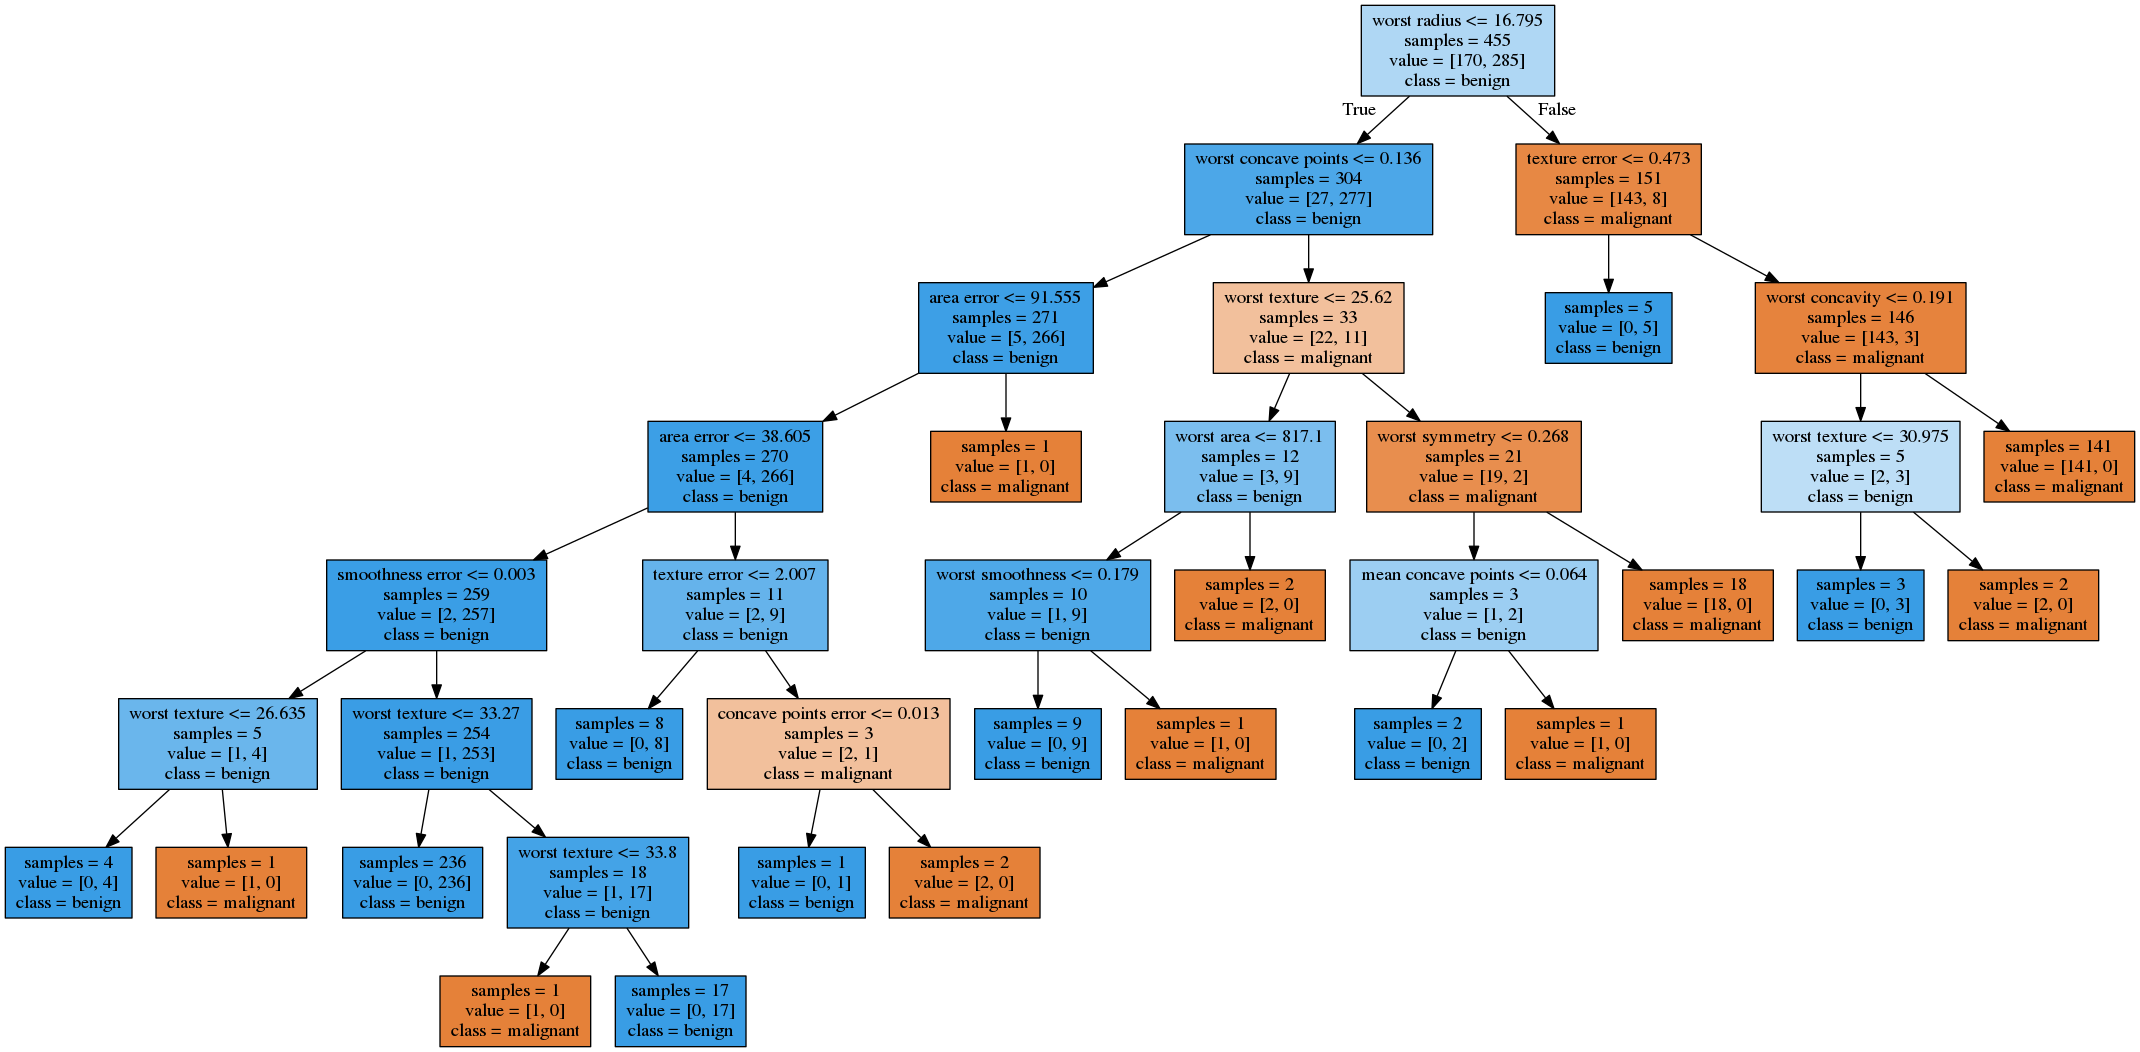

In [26]:
# Hiển thị file ảnh
from IPython.display import Image
Image(filename='tree_classifier.png')

** Mức độ quan trọng của các thuộc tính **

In [27]:
tree.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00626075, 0.        , 0.        ,
       0.        , 0.05266073, 0.        , 0.01208478, 0.00177016,
       0.        , 0.        , 0.00626075, 0.        , 0.        ,
       0.69781114, 0.05888116, 0.        , 0.01267802, 0.00845201,
       0.        , 0.01632512, 0.11608267, 0.01073271, 0.        ])

In [28]:
# Import matplotlib
import matplotlib.pyplot as plt

In [19]:
features = cancer.feature_names
n = len(features)
plt.figure(figsize = (8,10))
plt.barh(range(n), tree.feature_importances_)
plt.yticks(range(n), features)
plt.title('Muc do quan trong cac thuoc tinh')
plt.ylabel('Cac thuoc tinh')
plt.xlabel('Muc do')
plt.show()

NameError: name 'cancer' is not defined

In [18]:
tree.feature_importances_

NameError: name 'tree' is not defined

## 2.2 Tập dữ liệu auto

In [30]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [31]:
data = pd.read_csv("data/auto-mpg.csv")

In [32]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [33]:
x = data['displacement']
y = data['mpg']

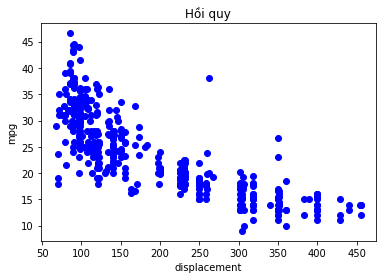

In [34]:
plt.scatter(x, y, c='blue')
plt.xlabel("displacement")
plt.ylabel("mpg")
plt.title("Hồi quy")
plt.show()

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [36]:
x = x.values.reshape(-1,1)
y = y.values.reshape(-1,1)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

In [38]:
dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, random_state=3)

In [39]:
dt.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=3, splitter='best')

In [40]:
y_pred = dt.predict(x_test)

In [41]:
mse_dt = MSE(y_test, y_pred)

In [42]:
print(np.sqrt(mse_dt))

4.710198071342834


In [43]:
xx = np.linspace(min(x), max(x), 400).reshape(-1,1)

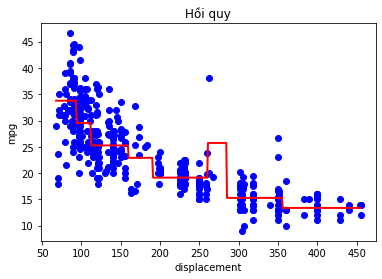

In [44]:
plt.scatter(x, y, c='blue')
plt.plot(xx, dt.predict(xx), color="red", linewidth=2)
plt.xlabel("displacement")
plt.ylabel("mpg")
plt.title("Hồi quy")
plt.show()

In [45]:
from sklearn.tree import export_graphviz
export_graphviz(dt, out_file='tree.dot', feature_names=['displacement'])

In [46]:
! dot -Tpng tree.dot > tree.png

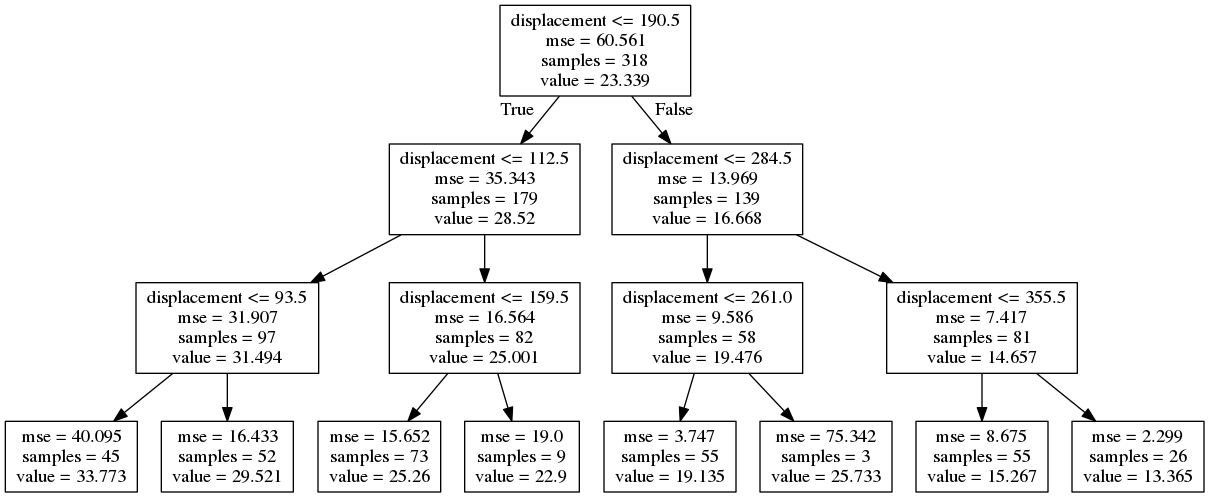

In [47]:
from IPython.display import Image
Image(filename='tree.png')

## Hồi quy cây ra quyết định

In [48]:
data = pd.read_csv("data/autompg.csv")
features = data.columns.values[1:][:-1]

In [49]:
features

array(['cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin'], dtype=object)

In [50]:
x = data[features].values

In [51]:
y = data['mpg']

In [52]:
regressor = DecisionTreeRegressor(max_depth=3)

In [53]:
regressor.fit(x, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [54]:
from sklearn.tree import export_graphviz 
export_graphviz(regressor, out_file='tree_multi.dot', feature_names=features)
! dot -Tpng tree_multi.dot > tree_multi.png

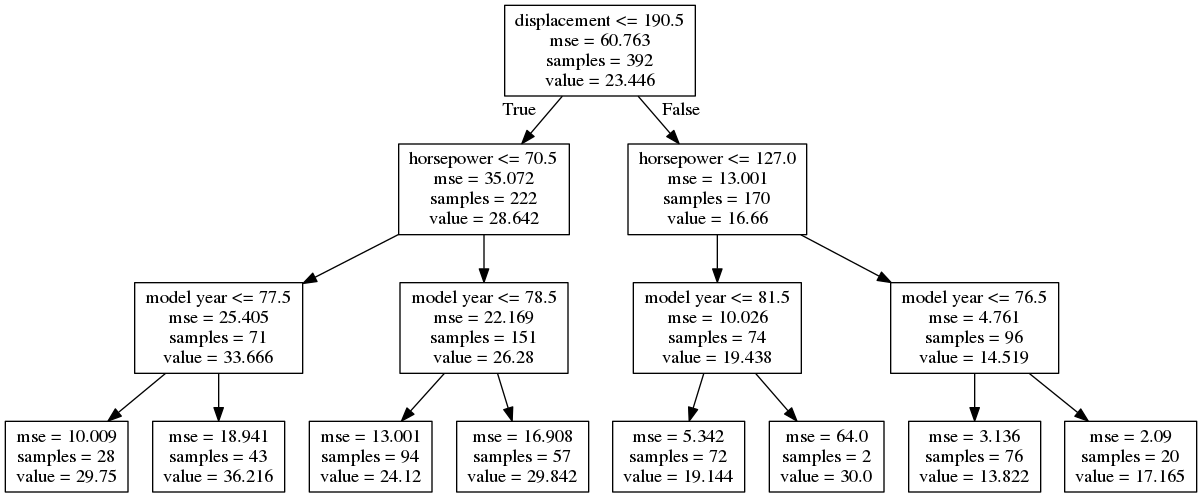

In [55]:
from IPython.display import Image
Image(filename = 'tree_multi.png')

In [56]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y, regressor.predict(x))

2.468336416856212

In [57]:
MSE(y, regressor.predict(x))

10.391210202107787